# Тестовое задание
Ответы подготовил Константин Фролов

Последнее обновление 29.09.2023 (после ревью)

## Описание ТЗ

Есть два файла, src_survey и src_OnOff.

В таблице src_survey результат опроса респондентов - участников исследования, целью которого является проверка работы оборудования и регистрации респондентов на пиплметре (измерительное устройство для фиксации телесмотрения).

В рамках каждой процедуры в одном домохозяйстве (ДХ) проверяется, кто из респондентов находится в комнате с включенным телевизором. В ДХ может быть несколько приборов (телевизоров), могут проживать несколько респондентов. В опросе содержится информация по каждому телевизору и каждому респонденту

Далее, результат опроса сравнивается с данными регистрации респондента на пиплметре во время опроса, результат сравнения фиксируется в таблице (см. описание полей)

Нужно проанализировать:
1.	Количество ситуаций (абс, %), когда прибор фактически выключен (данные в таблице src_OnOff), а респондент утверждает, что включен
2.	Количество ситуаций (абс, %), когда прибор фактически включен (данные в таблице src_OnOff), а респондент утверждает, что выключен
3.	Выделить ДХ с размером более 1 человека, среди них ситуации, телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет, а у других респондентов в этом ДХ регистрация на этом телевизоре есть. Необходимо сгруппировать результат в зависимости от размера ДХ.

Описание полей:
- статус телевизора по утверждению респондента: tv state
- размер ДХ: Кол-во человек в семье 4+
- наличие фактической регистрации на пиплметре: see
- наличие респондента в комнате с телевизором согласно опросу: display
- идентификатор ДХ: passport (PassportNumber в таблице src_OnOff)
- фактический статус телевизора: DeviceState (ON включен, OFF выключен)
- идентификатор респондента: button
- идентификатор телевизора: unit (UnitNumber в таблице src_OnOff)

Мы ждем:
1.	Скрипт Python
2.	Результат анализа (данные + небольшой аналитический комментарий)


## Получение данных

In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib as plt
import numpy as np

In [2]:
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
%cd /content/drive/My Drive/Analytics/Tests/test_1/

/content/drive/My Drive/Analytics/Tests/test_1


In [5]:
%ls

 figure.png        test_1.7z
 src_OnOff.xlsx    test1_upd.ipynb
 src_survey.xlsx  'Описание тестового задания (аналитик python).docx'


In [6]:
try:
  src_survey = pd.read_excel('src_survey.xlsx')
  src_on_off = pd.read_excel('src_OnOff.xlsx')
except NameError:
  print('NameError')

In [7]:
src_survey.info()
print()
src_survey.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   code                       207 non-null    int64 
 1   passport                   207 non-null    int64 
 2   button                     207 non-null    object
 3   tv state                   207 non-null    object
 4   unit                       207 non-null    int64 
 5   day                        207 non-null    object
 6   cs_start                   207 non-null    object
 7   cs_finish                  207 non-null    object
 8   see                        207 non-null    object
 9   display                    207 non-null    object
 10  Кол-во человек в семье 4+  207 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 17.9+ KB



,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
0,258104,1204558,А,выключен,0,07.02.22,16:25:18,16:26:09,нет регистрации,нет в комнате,1
1,258106,1205697,Б,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3
2,258106,1205697,А,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,нет в комнате,3
3,258106,1205697,В,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3
4,258109,1206994,А,выключен,1,2022-02-08 00:00:00,03:05:31,03:06:58,нет регистрации,нет в комнате,1


In [8]:
src_on_off.info()
print()
src_on_off.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PassportNumber  642134 non-null  int64 
 1   UnitNumber      642134 non-null  int64 
 2   DeviceState     642134 non-null  object
 3   Begin           642134 non-null  object
 4   End             642134 non-null  object
dtypes: int64(2), object(3)
memory usage: 24.5+ MB



,PassportNumber,UnitNumber,DeviceState,Begin,End
0,10100003,0,OFF,2022-02-07 02:00:00.000,2022-02-08 02:00:00.000
1,10100003,0,OFF,2022-02-08 02:00:00.000,2022-02-08 11:48:42.000
2,10100003,0,ON,2022-02-08 11:48:42.000,2022-02-08 12:36:55.000
3,10100003,0,OFF,2022-02-08 12:36:55.000,2022-02-08 22:05:17.000
4,10100003,0,ON,2022-02-08 22:05:17.000,2022-02-08 23:48:03.000


## Предобработка данных

Предобработаем обе таблицы по-очереди. Посмотрим на названия столбцов, типы данных и содержимое.

### Таблица src_survey

In [9]:
src_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   code                       207 non-null    int64 
 1   passport                   207 non-null    int64 
 2   button                     207 non-null    object
 3   tv state                   207 non-null    object
 4   unit                       207 non-null    int64 
 5   day                        207 non-null    object
 6   cs_start                   207 non-null    object
 7   cs_finish                  207 non-null    object
 8   see                        207 non-null    object
 9   display                    207 non-null    object
 10  Кол-во человек в семье 4+  207 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 17.9+ KB


In [10]:
print(f"Пропуски:\n{src_survey.isna().sum()}\n")
print(f"Дубликаты:\n{src_survey.duplicated().sum()}\n")

Пропуски:
code                         0
passport                     0
button                       0
tv state                     0
unit                         0
day                          0
cs_start                     0
cs_finish                    0
see                          0
display                      0
Кол-во человек в семье 4+    0
dtype: int64

Дубликаты:
0



In [11]:
# Копируем датафрейм для работы
src_survey1 = src_survey.copy()

In [12]:
# Приведем столбцы к единому регистру, дадим понятные названия
src_survey1 = src_survey1.rename(columns={'button':'respondent',
                                        'tv state':'tv_state',
                                        'cs_start':'start_watch',
                                        'cs_finish':'finish_watch',
                                        'see':'registry',
                                        'display':'in_room',
                                        'Кол-во человек в семье 4+':'people_count'})

In [13]:
src_survey1.columns

Index(['code', 'passport', 'respondent', 'tv_state', 'unit', 'day',
       'start_watch', 'finish_watch', 'registry', 'in_room', 'people_count'],
      dtype='object')

In [14]:
src_survey1['day'].value_counts().head(10)

14.02.22               90
07.02.22               60
15.02.22               33
16.02.22                9
09.02.22                8
08.02.22                3
2022-02-08 00:00:00     2
10.02.22                2
Name: day, dtype: int64

Мы видим, что столбец даты содержит одно значение в альтернативном формате. Поскольку ситуация стандартная и может встречаться часто, создадим функцию, которая будет обрабатывать тип значений по выбору.

In [15]:
# Функция для работы с датой
def convert_day_to_new_date(df):
    """
    Создает новый столбец с датой в формате datetime64[ns], старый удаляется.

    """
    # Создает копию датафрейма
    df = df.copy()

    # Создает столбец для определения типа значения #1
    df['format'] = 1

    # Создает столбец для определения типа значения #2
    df.loc[df['day'].str.contains(' ', na=True), 'format'] = 2

    # Конвертирует дату в желаемый формат
    def convert_date(date_str, format):
        """
        Преобразует строку даты в указанный формат

        """
        # Если формат равен 1, считывает значения как '%d.%m.%y'
        if format == 1:
            input_format = '%d.%m.%y'

        # Если формат равен 2, считывает значения как '%Y-%m-%d %H:%M:%S'
        elif format == 2:
            input_format = '%Y-%m-%d %H:%M:%S'

        # Преобразует строку в объект datetime, используя указанный выше формат
        date_obj = pd.to_datetime(date_str, format=input_format)

        # Возвращает преобразованную строку даты
        return date_obj

    # Применяет функцию convert_date к каждой строке датафрейма, используя столбцы day и format
    df['new_date'] = df.apply(lambda row: convert_date(row['day'],
                                                       row['format']), axis=1)

    # Удаляет старый столбец даты и технический столбец
    df = df.drop(['day', 'format'], axis=1)

    # Возвращает датафрейм с добавленным новым столбцом даты
    return df

In [16]:
# Применим функцию к датасету
src_survey1 = convert_day_to_new_date(src_survey1)

In [17]:
src_survey1['new_date']

0     2022-02-07
1     2022-02-07
2     2022-02-07
3     2022-02-07
4     2022-02-08
         ...    
202   2022-02-14
203   2022-02-14
204   2022-02-14
205   2022-02-14
206   2022-02-14
Name: new_date, Length: 207, dtype: datetime64[ns]

In [18]:
dif = src_survey1['new_date'].max() - src_survey1['new_date'].min()
print(f"Первая дата опроса: {src_survey1['new_date'].min()}")
print(f"Последняя дата опроса: {src_survey1['new_date'].max()}")
print(f"Разница в днях: {dif.days}")

Первая дата опроса: 2022-02-07 00:00:00
Последняя дата опроса: 2022-02-16 00:00:00
Разница в днях: 9


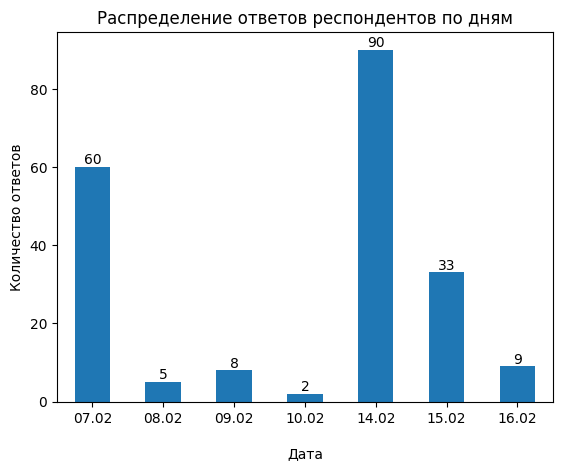

In [19]:
ax = src_survey1['new_date'].dt.strftime("%d.%m").sort_values().value_counts(sort=False).plot.bar(rot=0)
ax.set_title("Распределение ответов респондентов по дням")
ax.set_xlabel("\nДата")
ax.set_ylabel("Количество ответов")

for container in ax.containers:
    ax.bar_label(container)

В опросе представлены данные за 9 дней. Есть две особенности:
1. Даты идут не подряд. Скорее всего, опрос проводится только с понедельника по четверг. В таком случае выгрузка за две недели неполная: не хватает второго четверга.
2. Распределение значений неоднородное: больше всего информации по опросам 7 и 14 февраля 2022 года, то есть в начале недели.

Осталось создать единый столбец даты и времени. Для этого обработаем значения столбца времени.

In [20]:
print(src_survey1['start_watch'].tolist())
print(src_survey1['finish_watch'].tolist())

['16:25:18', '16:50:18', '16:50:18', '16:50:18', datetime.time(3, 5, 31), datetime.time(3, 5, 31), '14:31:41', '14:31:41', '14:31:41', '14:31:41', '18:49:46', '18:49:46', '18:49:46', '18:49:46', '19:02:54', '19:02:54', '19:02:54', '19:49:05', '19:20:08', '19:46:13', '19:46:13', '19:46:13', '19:46:13', '19:46:13', '19:46:13', '19:46:13', '19:46:13', '18:01:34', '18:01:34', '18:01:34', '18:01:34', '17:26:55', '17:26:55', '17:33:19', '17:33:19', '17:33:19', '17:33:19', '17:33:19', '17:33:19', '17:40:40', '17:40:40', '17:57:43', '17:57:43', '17:57:43', '17:57:43', '17:57:43', '17:57:43', '18:52:47', '18:52:47', '18:52:47', '18:52:47', '18:52:47', '18:52:47', '18:52:47', '18:52:47', '19:01:00', '19:01:00', '19:01:00', '19:01:00', '19:07:48', '19:07:48', '19:07:48', '19:07:48', '19:07:48', '19:07:48', '20:59:03', '20:59:03', '20:13:31', '20:13:31', '20:13:31', '20:13:31', '20:13:31', '20:13:31', '16:29:50', '16:29:50', '16:16:54', '20:11:05', '20:11:05', '20:11:05', '16:35:44', '16:35:44', '

Они имеют различный формат. Приведем их к общему виду.

In [21]:
for i in ['start_watch', 'finish_watch']:
    src_survey1[i] = pd.to_datetime(src_survey1[i],
                                    format='%H:%M:%S',
                                    errors='coerce').dt.time

Теперь объединим столбцы с датой и временем в один, чтобы затем соотнести значения с другой таблицей.

In [22]:
for i in ['start_watch', 'finish_watch']:
    src_survey1[i] = src_survey1['new_date'].astype(str) + ' ' + src_survey1[i].astype(str)
    src_survey1[i] = pd.to_datetime(src_survey1[i], format='%Y-%m-%d %H:%M:%S')

In [23]:
src_survey1[['start_watch', 'finish_watch']].head()

,start_watch,finish_watch
0,2022-02-07 16:25:18,2022-02-07 16:26:09
1,2022-02-07 16:50:18,2022-02-07 16:53:17
2,2022-02-07 16:50:18,2022-02-07 16:53:17
3,2022-02-07 16:50:18,2022-02-07 16:53:17
4,2022-02-08 03:05:31,2022-02-08 03:06:58


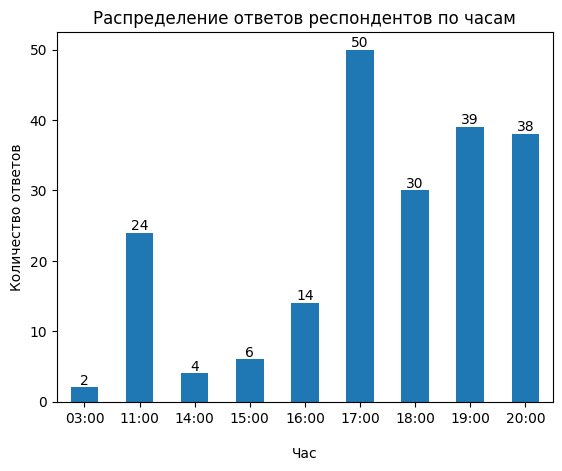

In [24]:
ax = src_survey1['start_watch'].dt.strftime("%H:00").sort_values().value_counts(sort=False).plot.bar(rot=0)
ax.set_title("Распределение ответов респондентов по часам")
ax.set_xlabel("\nЧас")
ax.set_ylabel("Количество ответов")

for container in ax.containers:
    ax.bar_label(container)

На основании графика выше можно сказать следующее:
1. Наблюдается подъем активности в ответах после 16:00.
2. Отсутствуют данные начиная с 21:00; много пропусков ночью, но это ожидаемо.
3. Первый всплеск значений находится в районе 11:00.

Наконец, посмотрим на значения других столбцов.

In [25]:
for i in ['respondent', 'tv_state', 'unit', 'registry', 'in_room', 'people_count']:
  print(f"Уникальные значения столбца \033[1m{i}\033[0m:\n{src_survey1[i].value_counts()} \n")

Уникальные значения столбца respondent:
А    71
Б    65
В    34
Г    21
Д    11
Е     4
З     1
Name: respondent, dtype: int64 

Уникальные значения столбца tv_state:
выключен    153
включён      54
Name: tv_state, dtype: int64 

Уникальные значения столбца unit:
0    104
1     72
2     31
Name: unit, dtype: int64 

Уникальные значения столбца registry:
нет регистрации     187
есть регистрация     20
Name: registry, dtype: int64 

Уникальные значения столбца in_room:
нет в комнате    182
в комнате         25
Name: in_room, dtype: int64 

Уникальные значения столбца people_count:
3    66
4    56
2    55
6    12
1    11
7     7
Name: people_count, dtype: int64 



Здесь аномальные значения не наблюдаются.

Столбец tv_state содежит логическую переменную, которая нам понадобится для следующего этапа, поэтому запишем значения в другом виде.

In [26]:
src_survey1.loc[src_survey1['tv_state'] == 'выключен', 'tv_state'] = 'OFF'
src_survey1.loc[src_survey1['tv_state'] == 'включён', 'tv_state'] = 'ON'

### Таблица src_on_off

In [27]:
src_on_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PassportNumber  642134 non-null  int64 
 1   UnitNumber      642134 non-null  int64 
 2   DeviceState     642134 non-null  object
 3   Begin           642134 non-null  object
 4   End             642134 non-null  object
dtypes: int64(2), object(3)
memory usage: 24.5+ MB


In [28]:
print(f"Пропуски:\n{src_on_off.isna().sum()}\n")
print(f"Дубликаты:\n{src_on_off.duplicated().sum()}\n")

Пропуски:
PassportNumber    0
UnitNumber        0
DeviceState       0
Begin             0
End               0
dtype: int64

Дубликаты:
0



In [29]:
src_on_off1 = src_on_off.copy()

In [30]:
src_on_off1 = src_on_off1.rename(columns={'PassportNumber':'passport',
                                        'UnitNumber':'unit',
                                        'DeviceState':'tv_state_fact',
                                        'Begin':'start_watch',
                                        'End':'finish_watch'})

In [31]:
src_on_off1['unit'].value_counts()

0    420864
1    166419
2     49660
3      4907
4       263
5        14
6         7
Name: unit, dtype: int64

Посмотрим на столбец tv_state_fact, который мы только что обработали в другой таблице.

In [32]:
src_on_off1['tv_state_fact'].value_counts()

OFF    364420
ON     277002
D         661
U          51
Name: tv_state_fact, dtype: int64

В этом столбце присутствуют значения неизвестной природы, от которых в данном случае можно либо избавиться, либо заменить значения на NaN. Для начала посмотрим, сколько строк со значениями "U" и "D" в tv_state_fact совпадают по passport в обеих таблицах.

In [33]:
a = src_on_off1[src_on_off1['passport'].isin(src_survey1['passport'])]

In [34]:
a[a['tv_state_fact'] == 'U']

,passport,unit,tv_state_fact,start_watch,finish_watch


In [35]:
a[a['tv_state_fact'] == 'D']

,passport,unit,tv_state_fact,start_watch,finish_watch
325115,1206092,0,D,2022-02-08 13:16:18.000,2022-02-08 13:16:46.000
325117,1206092,0,D,2022-02-08 13:16:50.000,2022-02-08 13:16:55.000
335279,1208602,2,D,2022-02-13 14:57:17.000,2022-02-13 14:57:22.000
366562,1211033,0,D,2022-02-11 06:06:28.000,2022-02-11 06:06:33.000


Итак, мы видим, что четыре строки (наши ДХ) имеют такой же passport, поэтому справедливее будет заменить значения на NaN.

In [36]:
src_on_off1.loc[src_on_off1['tv_state_fact'] == 'D', 'tv_state_fact'] = 'Unknown'
src_on_off1.loc[src_on_off1['tv_state_fact'] == 'U', 'tv_state_fact'] = 'Unknown'

In [37]:
src_on_off1['tv_state_fact'].value_counts()

OFF        364420
ON         277002
Unknown       712
Name: tv_state_fact, dtype: int64

In [38]:
src_on_off1['tv_state_fact'].isna().sum()

0

Осталось обработать значения столбцов времени.

In [39]:
src_on_off1[['start_watch', 'finish_watch']].head()

,start_watch,finish_watch
0,2022-02-07 02:00:00.000,2022-02-08 02:00:00.000
1,2022-02-08 02:00:00.000,2022-02-08 11:48:42.000
2,2022-02-08 11:48:42.000,2022-02-08 12:36:55.000
3,2022-02-08 12:36:55.000,2022-02-08 22:05:17.000
4,2022-02-08 22:05:17.000,2022-02-08 23:48:03.000


In [40]:
for i in ['start_watch', 'finish_watch']:
    src_on_off1[i] = pd.to_datetime(src_on_off1[i],
                                    format='%Y-%m-%d %H:%M:%S',
                                    errors='raise')

In [41]:
src_on_off1[['start_watch', 'finish_watch']].head()

,start_watch,finish_watch
0,2022-02-07 02:00:00,2022-02-08 02:00:00
1,2022-02-08 02:00:00,2022-02-08 11:48:42
2,2022-02-08 11:48:42,2022-02-08 12:36:55
3,2022-02-08 12:36:55,2022-02-08 22:05:17
4,2022-02-08 22:05:17,2022-02-08 23:48:03


In [42]:
dif2 = src_on_off1['finish_watch'].max() - src_on_off1['start_watch'].min()
print(f"Первая дата опроса: {src_on_off1['start_watch'].min()}")
print(f"Последняя дата опроса: {src_on_off1['finish_watch'].max()}")
print(f"Разница в днях: {dif2.days}")

Первая дата опроса: 2022-02-07 02:00:00
Последняя дата опроса: 2022-02-16 02:00:00
Разница в днях: 9


Text(0, 0.5, 'Количество просмотров')

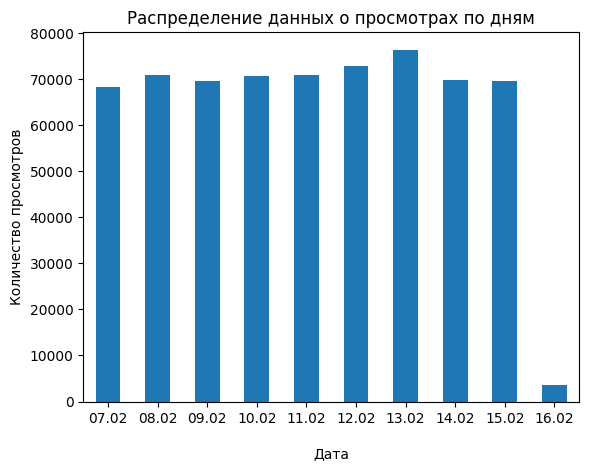

In [43]:
ax = src_on_off1['start_watch'].dt.strftime("%d.%m").sort_values().value_counts(sort=False).plot.bar(rot=0)
ax.set_title("Распределение данных о просмотрах по дням")
ax.set_xlabel("\nДата")
ax.set_ylabel("Количество просмотров")

В данном случае промежуток дат совпадает с первой таблицей, но порядок их появления последовательный, включая выходные. Данные представлены до 02:00 ночи 16.02, поэтому информация об этом дне далеко неполная.

## Объединение таблиц

In [44]:
src_survey1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   code          207 non-null    int64         
 1   passport      207 non-null    int64         
 2   respondent    207 non-null    object        
 3   tv_state      207 non-null    object        
 4   unit          207 non-null    int64         
 5   start_watch   207 non-null    datetime64[ns]
 6   finish_watch  207 non-null    datetime64[ns]
 7   registry      207 non-null    object        
 8   in_room       207 non-null    object        
 9   people_count  207 non-null    int64         
 10  new_date      207 non-null    datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(4)
memory usage: 17.9+ KB


In [45]:
src_on_off1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   passport       642134 non-null  int64         
 1   unit           642134 non-null  int64         
 2   tv_state_fact  642134 non-null  object        
 3   start_watch    642134 non-null  datetime64[ns]
 4   finish_watch   642134 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.5+ MB


Объединяем таблицы с помощью метода combine_first(), который дополняет пропущенные значения одной таблицы из другой.

In [46]:
src_survey1['tv_state_fact'] = np.NaN

In [47]:
result = src_survey1.combine_first(src_on_off1)

In [48]:
# Избавимся от тех лишних строк
result = result.dropna()

In [49]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   code           207 non-null    float64       
 1   finish_watch   207 non-null    datetime64[ns]
 2   in_room        207 non-null    object        
 3   new_date       207 non-null    datetime64[ns]
 4   passport       207 non-null    int64         
 5   people_count   207 non-null    float64       
 6   registry       207 non-null    object        
 7   respondent     207 non-null    object        
 8   start_watch    207 non-null    datetime64[ns]
 9   tv_state       207 non-null    object        
 10  tv_state_fact  207 non-null    object        
 11  unit           207 non-null    int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 21.0+ KB


In [50]:
result.head()

,code,finish_watch,in_room,new_date,passport,people_count,registry,respondent,start_watch,tv_state,tv_state_fact,unit
0,258104.0,2022-02-07 16:26:09,нет в комнате,2022-02-07,1204558,1.0,нет регистрации,А,2022-02-07 16:25:18,OFF,OFF,0
1,258106.0,2022-02-07 16:53:17,в комнате,2022-02-07,1205697,3.0,нет регистрации,Б,2022-02-07 16:50:18,ON,OFF,0
2,258106.0,2022-02-07 16:53:17,нет в комнате,2022-02-07,1205697,3.0,нет регистрации,А,2022-02-07 16:50:18,ON,ON,0
3,258106.0,2022-02-07 16:53:17,в комнате,2022-02-07,1205697,3.0,нет регистрации,В,2022-02-07 16:50:18,ON,OFF,0
4,258109.0,2022-02-08 03:06:58,нет в комнате,2022-02-08,1206994,1.0,нет регистрации,А,2022-02-08 03:05:31,OFF,ON,1


Как мы видим, количество строк (207) совпадает с таблицей src_survey1, добавился интересующий нас столбец tv_state_fact. Исправим порядок столбцов и форматирование.

In [51]:
result = result[['code',
                'passport',
                'unit',
                'respondent',
                'new_date',
                'start_watch',
                'finish_watch',
                'in_room',
                'registry',
                'people_count',
                'tv_state',
                'tv_state_fact']]

In [52]:
result[['code', 'people_count']] = result[['code', 'people_count']].astype('int64')

In [53]:
result.head()

,code,passport,unit,respondent,new_date,start_watch,finish_watch,in_room,registry,people_count,tv_state,tv_state_fact
0,258104,1204558,0,А,2022-02-07,2022-02-07 16:25:18,2022-02-07 16:26:09,нет в комнате,нет регистрации,1,OFF,OFF
1,258106,1205697,0,Б,2022-02-07,2022-02-07 16:50:18,2022-02-07 16:53:17,в комнате,нет регистрации,3,ON,OFF
2,258106,1205697,0,А,2022-02-07,2022-02-07 16:50:18,2022-02-07 16:53:17,нет в комнате,нет регистрации,3,ON,ON
3,258106,1205697,0,В,2022-02-07,2022-02-07 16:50:18,2022-02-07 16:53:17,в комнате,нет регистрации,3,ON,OFF
4,258109,1206994,1,А,2022-02-08,2022-02-08 03:05:31,2022-02-08 03:06:58,нет в комнате,нет регистрации,1,OFF,ON


## Вопросы №1 и №2

Сгруппируем данные по колонкам. Посчитаем абсолютные и относительные значения.

In [54]:
result_g = result.groupby(['tv_state', 'tv_state_fact']).size().reset_index()

In [55]:
result_g

,tv_state,tv_state_fact,0
0,OFF,OFF,84
1,OFF,ON,69
2,ON,OFF,29
3,ON,ON,25


In [56]:
result_g.columns = ["tv_state", "tv_state_fact", "count"]
result_g.loc[result_g["tv_state_fact"] == "OFF", "percent"] = round(
    (result_g["count"] / result_g[result_g["tv_state_fact"] == "OFF"]["count"].sum())
    * 100,
    1,
)
result_g.loc[result_g["tv_state_fact"] == "ON", "percent"] = round(
    (result_g["count"] / result_g[result_g["tv_state_fact"] == "ON"]["count"].sum())
    * 100,
    1,
)

In [57]:
result_g

,tv_state,tv_state_fact,count,percent
0,OFF,OFF,84,74.3
1,OFF,ON,69,73.4
2,ON,OFF,29,25.7
3,ON,ON,25,26.6


Визуализируем полученные данные.

In [58]:
#pip install -U kaleido

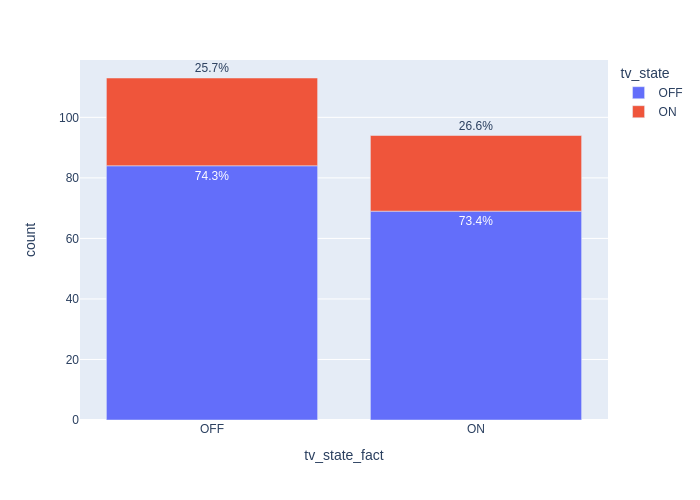

In [66]:
fig = px.bar(result_g,
             x='tv_state_fact',
             y='count',
             color='tv_state',
             text_auto=False,
             text=result_g['percent'].apply(lambda x: '{0:1.1f}%'.format(x)))
fig.update_traces(textfont_size=12,
                  textangle=0,
                  cliponaxis=False,
                  textposition="outside")
fig.write_image("figure.png", engine="kaleido")
fig.show(renderer='png')

**Выводы**

В представленной выше диаграмме мы имеем две колонки (слева - прибор фактически выключен, а справа - включен). Цвет характеризует ответы респондентов относительно состояния прибора (красный - включен, синий - выключен). При наведении курсора на диаграмму можно посмотреть абсолютные значения.

Данные по состоянию прибора и ответам респендентов распределены примерно одинаково, вне зависимости от фактического состояния устройства: 73-74% респондентов верно фиксируют факт, 26-27% сообщают неточную информацию.

## Вопрос №3

Выделим ДХ с размером более 1 человека, который соответствует описанию задачи: "телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет".

In [60]:
result1 = result.query('people_count > 1 and tv_state_fact == "ON" and in_room == "в комнате" and registry == "нет регистрации"')
result1

,code,passport,unit,respondent,new_date,start_watch,finish_watch,in_room,registry,people_count,tv_state,tv_state_fact
49,258128,1210930,1,Б,2022-02-07,2022-02-07 18:52:47,2022-02-07 18:54:12,в комнате,нет регистрации,4,ON,ON


Теперь среди найденных ДХ оставим только тех респондентов, которые есть в этих ДХ и у которых на этом же телевизоре есть регистрация.

In [61]:
result2 = result[result['passport'].isin(result1['passport'])]
result2 = result2[result2['unit'].isin(result1['unit'])].query('registry == "есть регистрация"')
result2

,code,passport,unit,respondent,new_date,start_watch,finish_watch,in_room,registry,people_count,tv_state,tv_state_fact
47,258128,1210930,1,А,2022-02-07,2022-02-07 18:52:47,2022-02-07 18:54:12,в комнате,есть регистрация,4,ON,ON


Сгруппируем результат в зависимости от размера ДХ.


In [62]:
result3 = result2.groupby('people_count').agg({'passport':'nunique'}).reset_index().rename(columns={'passport':'household_count'})
result3

,people_count,household_count
0,4,1


In [63]:
result['passport'].nunique()

45

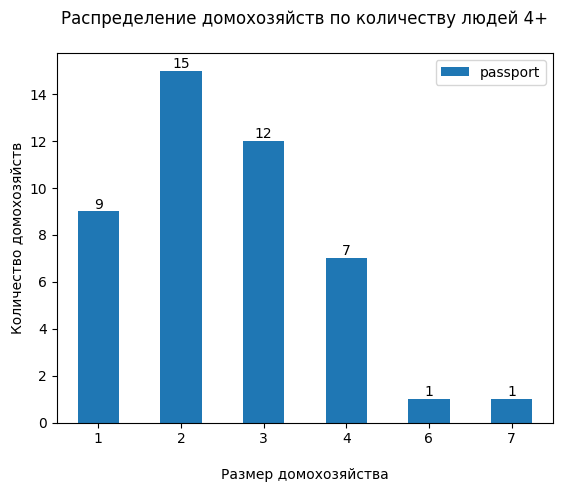

In [64]:
ax = result.groupby('people_count').agg({'passport':'nunique'}).plot.bar(rot=0)
ax.set_title("Распределение домохозяйств по количеству людей 4+\n")
ax.set_xlabel("\nРазмер домохозяйства")
ax.set_ylabel("Количество домохозяйств")

for container in ax.containers:
    ax.bar_label(container)

**Вывод**

Мы видим, что из 45 опрошенных ДХ осталось только одно подходящее под описание. Оно состоит из 4 человек.